1. What is the problem that Glorot initialization and He initialization aim
to fix?
> Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.

2. Is it OK to initialize all the weights to the same value as long as that
value is selected randomly using He initialization?
> No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.


3. Is it OK to initialize the bias terms to 0?
> It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.

4. In which cases would you want to use each of the activation functions
we discussed in this chapter?

* ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration.

* The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost.

* The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets.

* The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17).

* The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. 

* The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.

5. What may happen if you set the momentum hyperparameter too close to
1 (e.g., 0.99999) when using an SGD optimizer?
> If you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.


6. Name three ways you can produce a sparse model.
>One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ1 regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.

7. Does dropout slow down training? Does it slow down inference (i.e.,
making predictions on new instances)? What about MC dropout?
> Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

8. Practice training a deep neural network on the CIFAR10 image dataset:

> a. Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.

In [1]:
import tensorflow as tf

tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32,3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100,activation="swish",
                                    kernel_initializer="he_normal"))
    

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


> b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with tf.keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.

In [2]:
# Adding output layer
model.add(tf.keras.layers.Dense(10,activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [3]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
# Loading CIFAR10 dataset
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full,y_train_full),(X_test,y_test) = cifar10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 69s 0us/step


In [5]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [6]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                         save_best_only=True)
from pathlib import Path
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb,model_checkpoint_cb,tensorboard_cb]


In [7]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [8]:
model.fit(X_train,y_train,epochs=100,
          validation_data=(X_valid,y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.1392 - loss: 24.0809 - val_accuracy: 0.1984 - val_loss: 2.3205
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2153 - loss: 2.2372 - val_accuracy: 0.2568 - val_loss: 2.0980
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2529 - loss: 2.0582 - val_accuracy: 0.2874 - val_loss: 1.9832
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2887 - loss: 1.9595 - val_accuracy: 0.3052 - val_loss: 1.9169
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3157 - loss: 1.8911 - val_accuracy: 0.3290 - val_loss: 1.8332
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.3396 - loss: 1.8290 - val_accuracy: 0.3500 - val_loss: 1.8082
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3555 - loss: 1.7758 - val_accuracy: 0.3504 - val_loss: 1.7881
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy:

In [9]:
model.evaluate(X_valid,y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4481 - loss: 1.5651


[1.574840784072876, 0.4424000084400177]

> c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

In [15]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.1864 - loss: 2.2226 - val_accuracy: 0.3152 - val_loss: 1.9800
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.3415 - loss: 1.8162 - val_accuracy: 0.3678 - val_loss: 1.7777
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.3926 - loss: 1.6878 - val_accuracy: 0.3856 - val_loss: 1.6994
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.4319 - loss: 1.5968 - val_accuracy: 0.3880 - val_loss: 1.6845
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.4579 - loss: 1.5241 - val_accuracy: 0.3822 - val_loss: 1.7270
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.4837 - loss: 1.4566 - val_accuracy: 0.3894 - val_loss: 1.7192
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5025 - loss: 1.3945 - val_accuracy: 0.3976 - val_loss: 1.6906
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 

[1.6845201253890991, 0.3880000114440918]

* *Is the model converging faster than before?* Much faster! The previous model took 43 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 23 epochs and continued to make progress until the 23rd epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 72.3% validation accuracy instead of 55.0%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

> d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [14]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10,activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model.keras" ,save_best_only=True
)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb,model_checkpoints_cb,tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled,y_train,epochs=100,
          validation_data=(X_valid_scaled,y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled,y_valid)

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2737 - loss: 2.0471 - val_accuracy: 0.3710 - val_loss: 1.7810
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3868 - loss: 1.7248 - val_accuracy: 0.3978 - val_loss: 1.6923
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4250 - loss: 1.6230 - val_accuracy: 0.4368 - val_loss: 1.6323
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4561 - loss: 1.5469 - val_accuracy: 0.4332 - val_loss: 1.6292
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4751 - loss: 1.4952 - val_accuracy: 0.4582 - val_loss: 1.5861
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4987 - loss: 1.4422 - val_accuracy: 0.4656 - val_loss: 1.5717
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5222 - loss: 1.3880 - val_accuracy: 0.4690 - val_loss: 1.5576
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5289 

[1.5228419303894043, 0.4885999858379364]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 48.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

> e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [16]:
import keras.layers

tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))
    
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model.keras",save_best_only=True
)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb,model_checkpoint_cb,tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled,y_train,epochs=100,
          validation_data=(X_valid_scaled,y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled,y_valid)


C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2723 - loss: 2.0723 - val_accuracy: 0.4022 - val_loss: 1.7003
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3997 - loss: 1.6956 - val_accuracy: 0.4276 - val_loss: 1.6504
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4383 - loss: 1.5942 - val_accuracy: 0.4484 - val_loss: 1.5880
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4690 - loss: 1.5214 - val_accuracy: 0.4702 - val_loss: 1.5933
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4893 - loss: 1.4689 - val_accuracy: 0.4642 - val_loss: 1.5699
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5090 - loss: 1.4144 - val_accuracy: 0.4654 - val_loss: 1.6174
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5223 - loss: 1.3639 - val_accuracy: 0.4848 - val_loss: 1.5944
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.

[1.569853663444519, 0.4641999900341034]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.



Let's use MC Dropout now. We will need the MCAlphaDropout class we used earlier, so let's just copy it here for convenience:

In [21]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self,inputs):
        return super().call(inputs,training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with MCAlphaDropout dropout layers instead of AlphaDropout layers:

In [22]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer,keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [23]:
import numpy as np
def mc_dropout_predict_probas(mc_model,X,n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas,axis=0)

def mc_dropout_predict_classes(mc_model,X,n_samples=10):
    Y_probas =mc_dropout_predict_probas(mc_model,X,n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [24]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model,X_valid_scaled)
accuracy = (y_pred == y_valid[:,0]).mean()
accuracy

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.4642

> f.
Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [25]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

In [28]:
import math
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [29]:
import matplotlib.pyplot as plt
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1517 - loss: nan


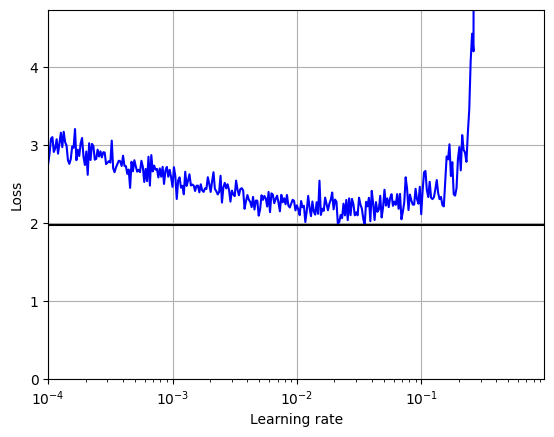

In [30]:
batch_size  = 128
rates,losses = find_learning_rate(model,X_train_scaled,y_train,
                                  epochs=1,batch_size=batch_size)

plot_lr_vs_loss(rates,losses)

In [31]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self,iterations,max_lr = 1e-3,start_lr=None,
                 last_iterations=None,last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self,iter1,iter2,lr1,lr2):
        return (lr2-lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1
    
    def on_batch_begin(self,batch,logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0,self.half_iteration,self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr,self.start_lr)
        else:
            lr = self._interpolate(2* self.half_iteration,self.iterations,
                                   self.max_lr,self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr


In [34]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2318 - loss: 2.2404 - val_accuracy: 0.3804 - val_loss: 1.7564
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3631 - loss: 1.8062 - val_accuracy: 0.4162 - val_loss: 1.6708
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4213 - loss: 1.6440 - val_accuracy: 0.4192 - val_loss: 1.6578
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4484 - loss: 1.5589 - val_accuracy: 0.4288 - val_loss: 1.6729
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4715 - loss: 1.4983 - val_accuracy: 0.4410 - val_loss: 1.6715
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4890 - loss: 1.4509 - val_accuracy: 0.4450 - val_loss: 1.6729
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4974 - loss: 1.4154 - val_accuracy: 0.4614 - val_loss: 1.6226
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5218 - loss: 1.3525 - val_accurac

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).